In [1]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis
slim = tf.contrib.slim

from tensorflow.contrib.distributions import percentile as tf_percent



In [2]:
data = pd.read_csv("./../data/credit44_sc.csv" )

In [3]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def log(x):
    return tf.log(x + 1e-8)

In [4]:
mb_size = 1000
X_dim = np.shape(data)[1]
z_dim = 32 # Good :  64 | 32
h_dim = 64 # Good : 128 | 64
lr = 1e-4
d_steps = 3


mb_size = 32
X_dim = np.shape(data)[1]
z_dim = 64
h_dim = 128
lr = 1e-3
d_steps = 3

나쁘지 않게 나온다.

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])



def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def mapping_net( Z , hsize = None , reuse = tf.AUTO_REUSE) : 
    with tf.variable_scope("Map" , reuse = reuse) : 
        h = tf.layers.dense(Z,hsize[0], activation=tf.nn.elu )
        h = tf.layers.dense(h,hsize[0], activation=tf.nn.leaky_relu)
        #h = slim.dropout(h, keep_prob=0.9  , scope='dropout_map_1st')
        for i in np.arange( len(hsize)-1 )  : 
            h = tf.layers.dense(h,hsize[i+1],activation=tf.nn.elu ,
                                name="map_w_"+str(i) ) #  , kernel_initializer = tf.variance_scaling_initializer()
            h = tf.contrib.layers.batch_norm(h , decay=0.1 , renorm_clipping= (0 , 1) ,activation_fn = tf.nn.selu   )
        return h


def D(X, hsize=None  ,reuse=tf.AUTO_REUSE ):
    with tf.variable_scope( "Discriminator" ,reuse=reuse  ):
        h = tf.layers.dense(X,hsize[0], activation=tf.nn.relu , kernel_initializer= tf.contrib.layers.xavier_initializer() )
        for i in np.arange( len(hsize)-1 )  : 
            h = tf.layers.dense(h,hsize[i+1],activation=tf.nn.relu ,
                                name="total_w_"+str(i), kernel_initializer= tf.contrib.layers.xavier_initializer() )
        out = tf.layers.dense(h,1 ,activation=tf.nn.sigmoid ) # 
    return out


def G( Z , hsize = None , reuse = tf.AUTO_REUSE) : 
    with tf.variable_scope("Generator" , reuse = reuse) : 
        h = tf.layers.dense(Z,hsize[0], activation=tf.nn.relu , kernel_initializer= tf.contrib.layers.xavier_initializer())
        for i in np.arange( len(hsize)-1 )  : 
            h = tf.layers.dense(h,hsize[i+1],activation=tf.nn.relu ,
                                name="relu_w_"+str(i) , kernel_initializer= tf.contrib.layers.xavier_initializer()) #  , kernel_initializer = tf.variance_scaling_initializer()
        G_prob = tf.layers.dense(h, X_dim , activation=tf.nn.sigmoid )
    return G_prob





In [6]:
hsize =[h_dim] * 1
hsize2 = [z_dim] * 3
W = mapping_net(z , hsize2)
G_sample = G(W, hsize)
hsize =[h_dim]
D_real = D(X , hsize)
D_fake = D(G_sample , hsize)


Z = tf.reduce_sum(tf.exp(-D_real)) + tf.reduce_sum(tf.exp(-D_fake))

D_loss = -tf.reduce_mean(log(D_real) + log(1 - D_fake))
G_loss = 0.5 * tf.reduce_mean((log(D_fake) - log(1 - D_fake))**2)

theta_M = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Map")
theta_G = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Generator")
theta_D = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Discriminator")



D_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(D_loss, var_list=theta_D))

gen_vars = []
gen_vars.append(theta_M)
gen_vars.append(theta_G)
G_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(G_loss, var_list=gen_vars ))

In [7]:
theta_M

[<tf.Variable 'Map/dense/kernel:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'Map/dense/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'Map/dense_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/map_w_0/kernel:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'Map/map_w_0/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/map_w_1/kernel:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'Map/map_w_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/BatchNorm_1/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/BatchNorm_1/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Map/BatchNorm_1/moving_variance:0' shape=(32,) dtype=float3

In [8]:
fac_var = []
num_var = []
for i in list(data) : 
    if data[i].nunique() < 15 : 
        print("factor variable : {}, count : {} ".format(i, data[i].nunique()))
        fac_var.append(i)
        if data[i].nunique() == 2 :
            print("binary" , i)
    else : 
        print("연속형 variable : {} , count : {} ".format(i, data[i].nunique()))
        num_var.append(i)
        
data = data.loc[:,fac_var + num_var]

col = list(data)

연속형 variable : SCORE_ORG , count : 395 
연속형 variable : SCORE_NK0200_000 , count : 445 
연속형 variable : SCORE_RK0400_700 , count : 294 
factor variable : CNT_CONTACT_POS, count : 8 
factor variable : CNT_ENG, count : 7 
factor variable : DAYS_CONTACT_POS, count : 11 
factor variable : DAYS_CALL_PAYMENT, count : 11 
factor variable : EWS_C_N_P27000100, count : 14 
연속형 variable : EWS_A_K_D1M232000_OPR , count : 2384 
factor variable : EWS_C_N_P42000200, count : 14 
연속형 variable : EWS_C_N_P32003000 , count : 31 
연속형 variable : AGE , count : 54 
연속형 variable : CNT_Contact , count : 29 
연속형 variable : EWS_A_K_D1M23200C_OPR , count : 2384 
연속형 variable : EWS_C_K_D10310000_OPR , count : 52 
연속형 variable : EWS_A_K_D90232200_OPR , count : 2490 
연속형 variable : D_N_CA0000603 , count : 4894 
연속형 variable : EWS_C_N_P32002600 , count : 22 
연속형 variable : EWS_D_N_P43004000 , count : 399 
factor variable : C_N_PS0001777, count : 11 
factor variable : A_K_D10220000_OPR, count : 9 
연속형 variable : SCORE_RK

In [9]:
from sklearn.preprocessing import MinMaxScaler

def sample_data(data = None , n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output

scaler = MinMaxScaler()

x_plot = pd.DataFrame(sample_data(data = data.values , n=mb_size) , columns = col)
# data["DAYS_CONTACT_POS"] = data["DAYS_CONTACT_POS"].replace({ 7777.0 : 10.0 })
# data["DAYS_CALL_PAYMENT"]= data["DAYS_CALL_PAYMENT"].replace({ 7777.0 : 10.0 })

data = scaler.fit_transform(data)

In [10]:
def show_plot( row , ncol ) : 
    
    fig , axes = plt.subplots(row , ncol , figsize = (26,13))
    fig.subplots_adjust(hspace = 0.2 , wspace= 0.23 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)
    total = sess.run(G_sample, feed_dict={z: sample_z(mb_size, z_dim)})
    try : 
        total = total[~np.isnan(total).any(axis=1)]
#         total = pd.DataFrame(total , columns = col )
#         total["DAYS_CONTACT_POS"].mask(total["DAYS_CONTACT_POS"] > 0.64, 1.0, inplace=True)
#         total["DAYS_CALL_PAYMENT"].mask(total["DAYS_CALL_PAYMENT"] > 0.59 , 1.0, inplace=True)
#         total = total.values
        total = scaler.inverse_transform(total)
        g_plot = pd.DataFrame(total , columns = col )
        
        g_plot[fac_var] = g_plot[fac_var].round(0)
        """
        좀 더 쉬운 분포로 만들어서 학습시킨 후 다시 원래값으로 (factor 변수이기 때문에 가능하다 생각함.)
        """
        #g_plot['DAYS_CONTACT_POS'].replace(to_replace=[1.0], value=7777.0, inplace=True)
        #g_plot['DAYS_CONTACT_POS'].mask(g_plot['DAYS_CONTACT_POS'] > 0.5 , 7777.0, inplace=True)
        #g_plot['DAYS_CALL_PAYMENT'].replace(to_replace=[1.0], value=7777.0, inplace=True)
        STAT4 = pd.read_csv("./describe.csv")
        SKEW = pd.DataFrame(g_plot.skew() , columns = ["skew"]).T
        KURT = pd.DataFrame(g_plot.kurt() , columns = ["kurt"]).T
        STAT2 = pd.concat([SKEW , KURT])
        STAT3 =pd.concat([g_plot.describe(), STAT2])
        stat4 = pd.concat([STAT4 , STAT3])
        # .rename( [STAT3.index.tolist()*2] )
        stat4.index = STAT3.index.tolist()*2
        stat4.to_csv("./real_fake_describe_boundary.csv")
        print("통계량 값 저장")
        
        col2 = 0

        for j in range(row) :
            for k in range(ncol) :
                try :
                    label = col[col2]
                    sample = g_plot.loc[: , label]
                    sample.name = "Gene"
                    real_0 = x_plot.loc[: , label]
                    real_0.name ="Real"
                    col2 += 1
                    if label in fac_var : 
                        sns.distplot( sample , ax=axes[j , k], norm_hist =True , kde=False , hist_kws ={"color":"r" , "label" :"Gene", "rwidth":0.75})
                        sns.distplot(real_0 , ax=axes[j , k],norm_hist =True, kde=False , hist_kws ={"color":"g" , "label" :"Real", "rwidth":0.75})
                        axes[j , k].legend(fontsize = 10)
                    elif label in num_var : 
                        sns.distplot(  sample , ax=axes[j , k] ,
                                     kde_kws={"color": "r", "lw": 2, "label": "Gene" , "shade" : True} , hist =False , rug = False) #   
                        sns.distplot(  real_0 , ax=axes[j , k] ,
                                     kde_kws={"color": "g", "lw": 2, "label": "Real", "shade" : True } , hist =False , rug = False) # 
                        axes[j , k].legend(fontsize = 10 )
                    axes[j , k].set_title( label , loc ="left" , fontsize= 10 )
                except IndexError as e : 
                    axes[j , k].axis("off")

        plt.suptitle('Boundary Iteration {} , Residual_loss : {} , D_loss : {} , G_loss : {}'.format(i,res , dloss,gloss) , fontsize= 30)
        plt.savefig("./visualization_boundary_Map2.png")
        plt.show()
        
        """
        Share 분포 역할
        """
        SHARE2 = sess.run( W , feed_dict={z: z_mb})
        pd.DataFrame( SHARE2 ).hist(figsize = (15, 15) , density=True )
        plt.suptitle("Share Output Distribution" , fontsize= 20)
        plt.subplots_adjust(hspace = 0.2 , wspace= 0.14 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)
        plt.savefig("./Share_Z_Dist_Map.png")
        plt.show()
        

        fig , ax = plt.subplots(figsize = (26,13))
        fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)

        ax.plot(output.iter , output.dloss , label ="dloss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.plot(output.iter , output.gloss , label ="gloss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
#         ax.plot(output.iter , output.stat , label ="stat" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
#         ax.plot(output.iter , output.dfac , label ="D_FAC" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
#         ax.plot(output.iter , output.dnum , label ="D_NUM" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
#         ax.plot(output.iter , output.dtotal , label ="D_TOTAL" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.set_title("Iter : {} , Res : {}(>6) , Dloss : {} , Gloss : {}(>2) stat loss : {}".format(iteration-1 ,  res , dloss, gloss , 0), fontsize= 30)
        ax.set_ylim(-5, 15)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4 , fontsize= 20)
        plt.savefig("./iteration_plot_bondary_Map2.png")
        plt.show()
        
    except Exception as e : 
        print(e)


Iter: 50750; D_loss: 0.9882; G_loss: 0.5188
통계량 값 저장


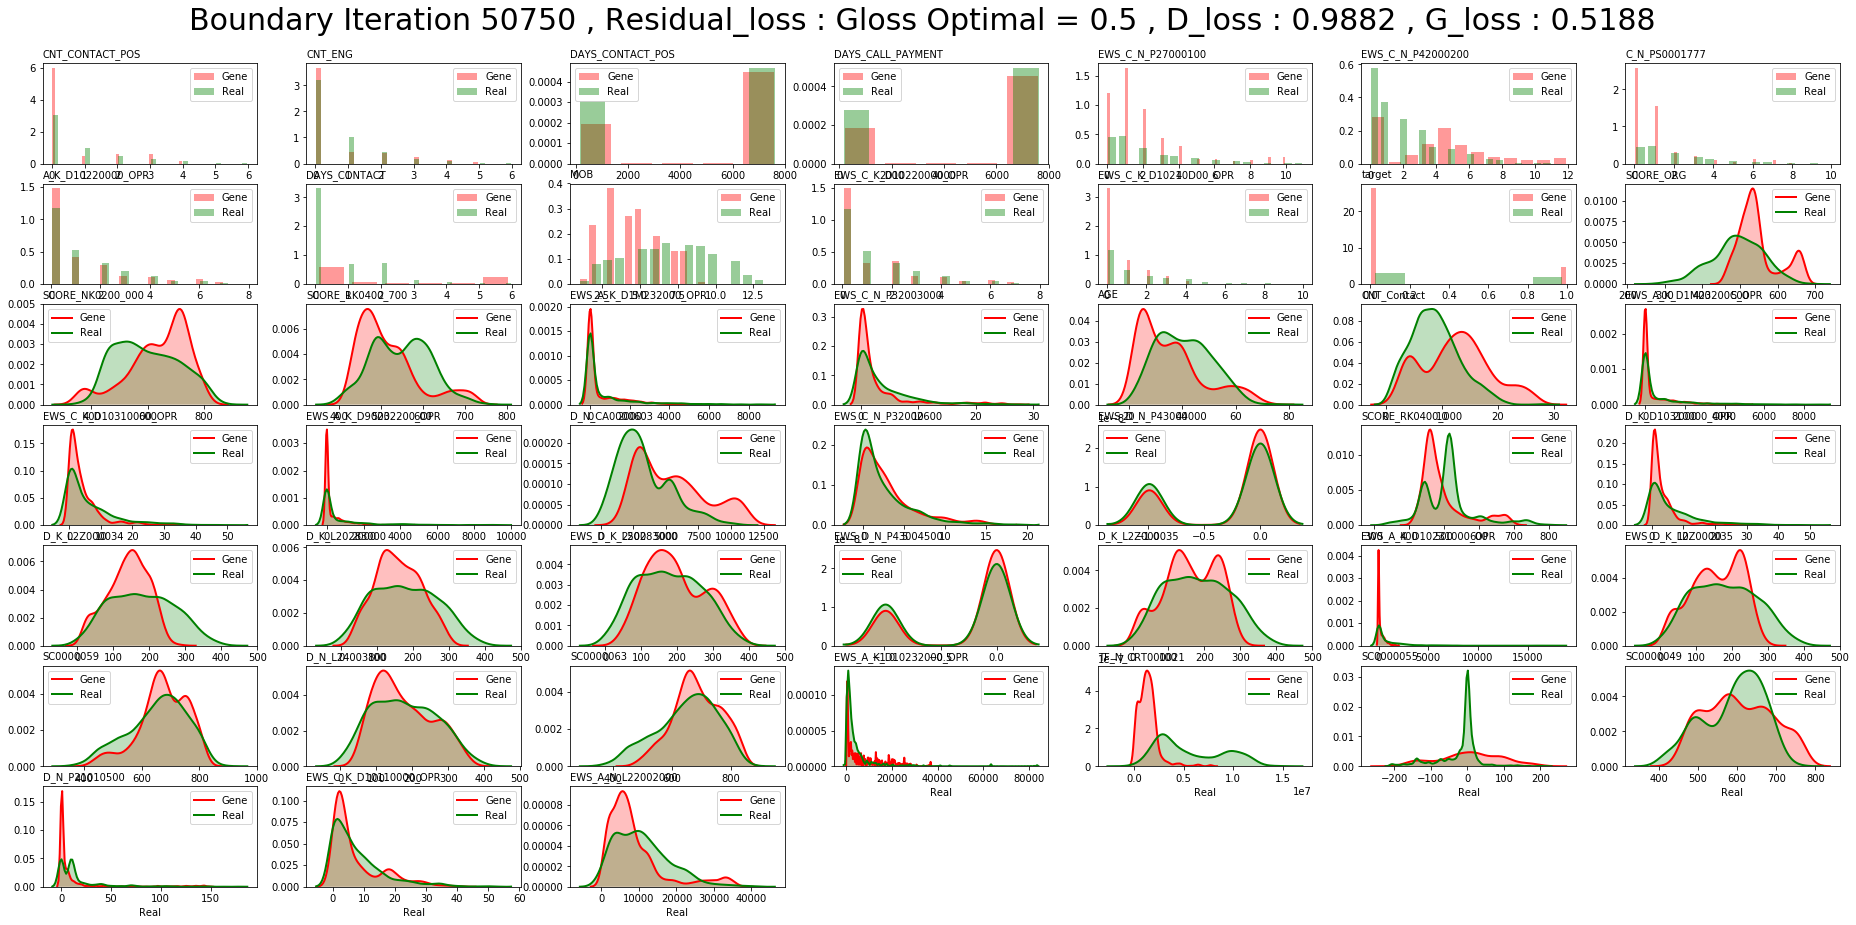

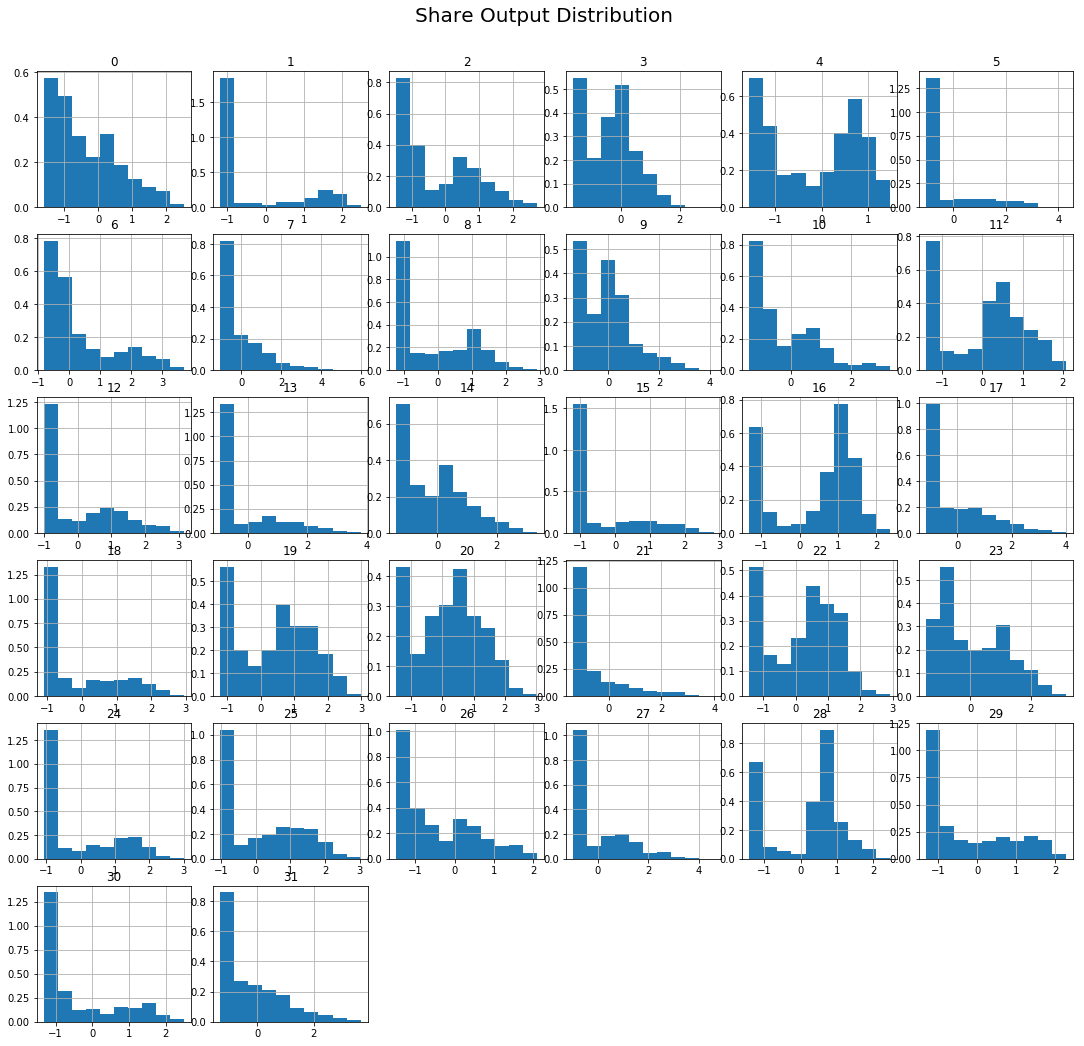

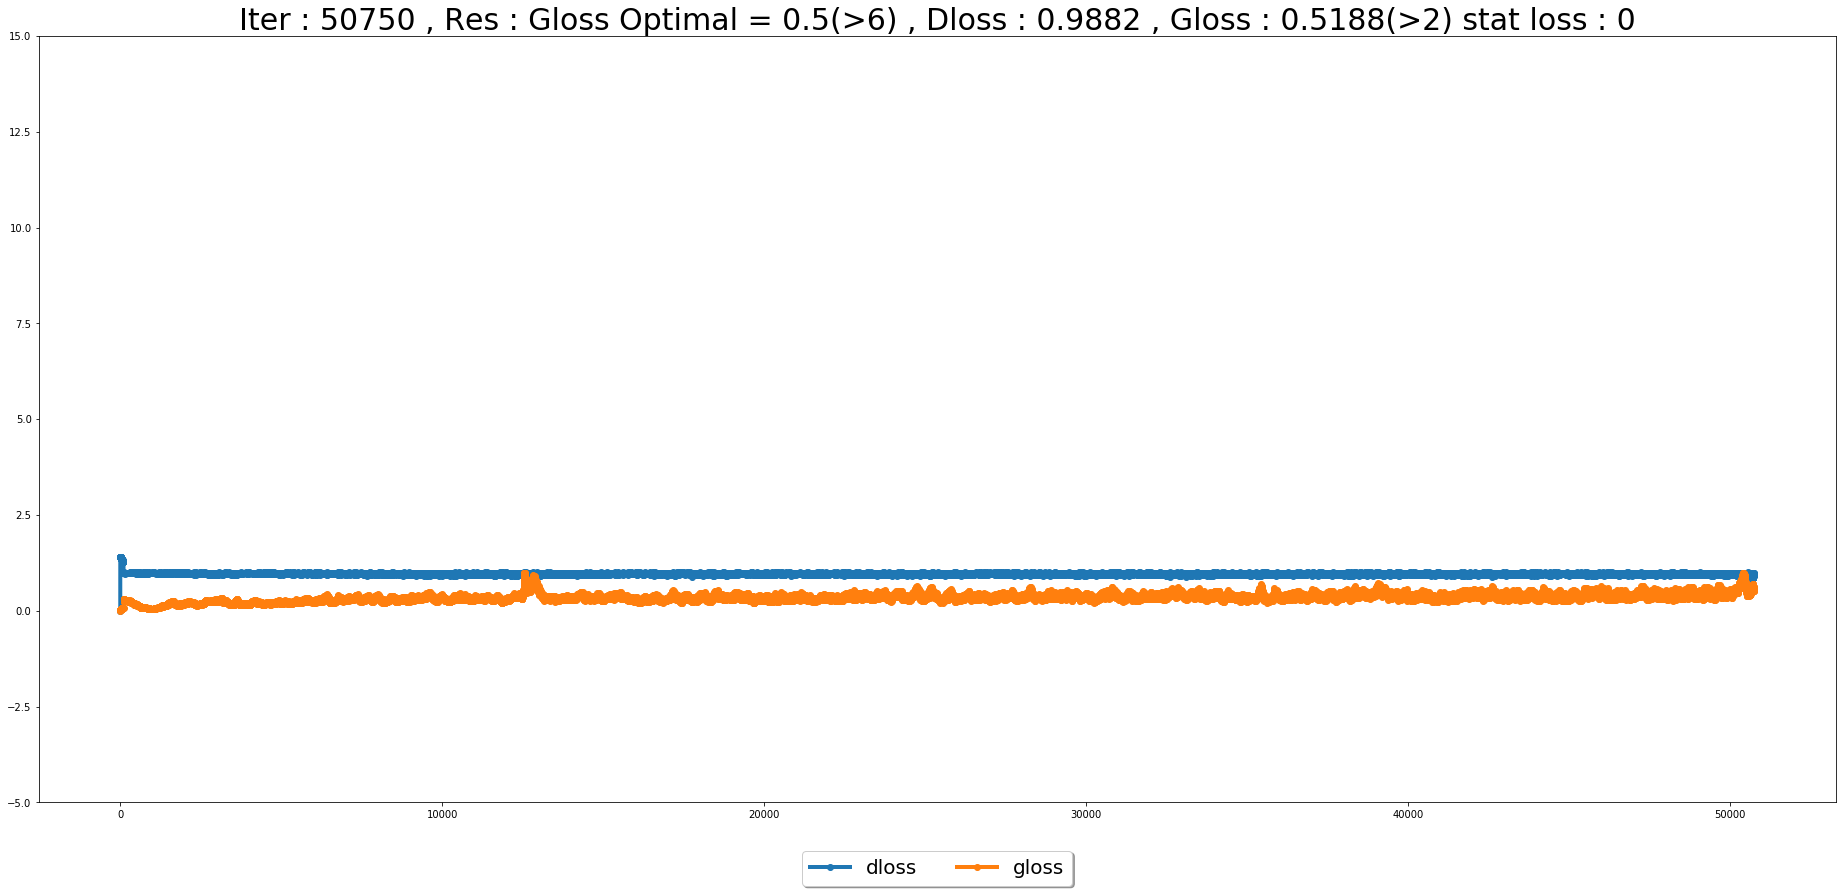

In [ ]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

i = 0

iteration , dloss ,  gloss = 0 , 0, 0
output = pd.DataFrame({"iter" : [iteration] , "dloss" : [dloss] , "gloss" : [gloss] })

for i in range(1000000):
    X_mb = sample_data(data = data , n=mb_size)
    z_mb = sample_z(mb_size, z_dim)

    _, dloss = sess.run(
        [D_solver, D_loss], feed_dict={X: X_mb, z: z_mb})

    _, gloss = sess.run(
        [G_solver, G_loss], feed_dict={X: X_mb, z: z_mb})
    iteration +=1
    if i < 100 : 
        D_limit = 1.5
        G_limit = 1.5
    elif (i >= 100) & (i < 200) :
        D_limit = 1
        G_limit = 1
    else : 
        D_limit = 1
        G_limit = 1
    dcount = 0 
    while dloss > D_limit  : 
        dcount += 1
        _, dloss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, z: z_mb})
        if dcount > 2000 :
            print("{}th  Dicriminator Loss : {}".format(i, dloss) )
            break
    gcount = 0 
    while gloss > G_limit :
        gcount += 1 
        _, gloss = sess.run([G_solver, G_loss], feed_dict={X: X_mb, z: z_mb})
        if gcount > 2000 :
            print(" {}th  Generate Loss : {}".format(i, gloss) )
            break
        
    output1 = pd.DataFrame({"iter" : [iteration] , "dloss" : [dloss] , "gloss" : [gloss] })
    output  = output.append(output1)
    if i % 50 == 0:
        clear_output(wait= True)
        dloss = round( np.float64(dloss),4)
        gloss = round( np.float64(gloss),4)
        print('Iter: {}; D_loss: {:.4}; G_loss: {:.4}'
              .format(i, dloss, gloss))
        res ="Gloss Optimal = 0.5"
        show_plot( row = 7 , ncol=7)